Columns in the DataFrame:
['id', 'Home', 'Away', 'Date', 'Stadium', 'Attendance', 'Referee', 'events', 'summary']

Mask Mapping Dictionary (Lowercased):
{'arsenal': 'Team_1', 'aston villa': 'Team_2', 'bournemouth': 'Team_3', 'brentford': 'Team_4', 'brighton & hove albion': 'Team_5', 'brighton': 'Team_5', 'burnley': 'Team_6', 'chelsea': 'Team_7', 'crystal palace': 'Team_8', 'everton': 'Team_9', 'fulham': 'Team_10', 'liverpool': 'Team_11', 'luton town': 'Team_12', 'manchester city': 'Team_13', 'man city': 'Team_13', 'manchester united': 'Team_14', 'newcastle united': 'Team_15', 'newcastle': 'Team_15', 'nottingham forest': 'Team_16', 'sheffield united': 'Team_17', 'tottenham hotspur': 'Team_18', 'tottenham': 'Team_18', 'west ham united': 'Team_19', 'west ham': 'Team_19', 'wolves': 'Team_20'}

Masked Home and Away Teams:
          Home Home_Masked            Away Away_Masked
0  Bournemouth      Team_3        West Ham     Team_19
1     Man City     Team_13       Newcastle     Team_15
2    B

/var/folders/c_/rs13jmts3nbf9xfm917mh9p80000gn/T/ipykernel_13025/2822594582.py:209: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Auto_Label", palette="viridis")


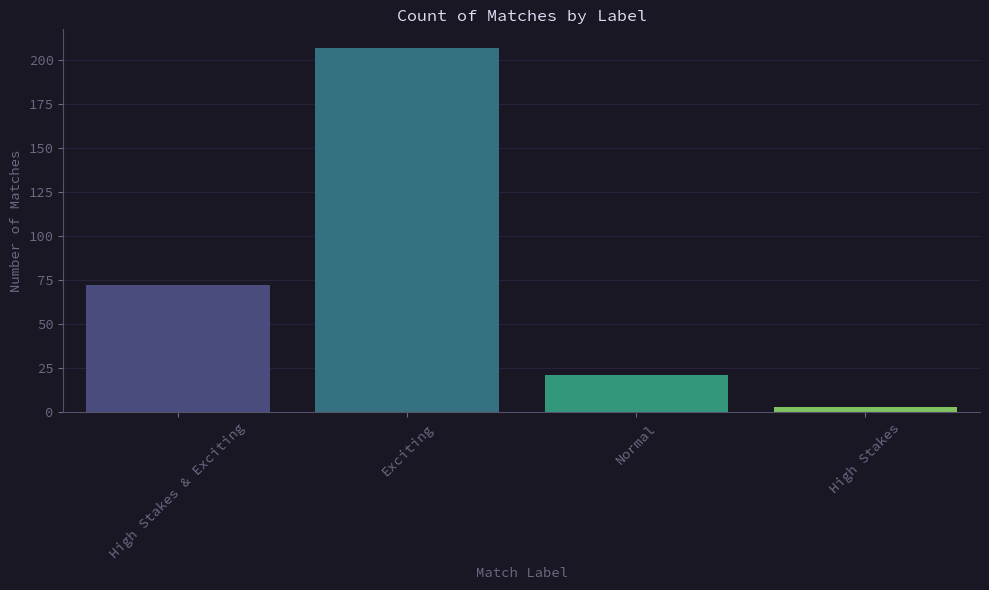

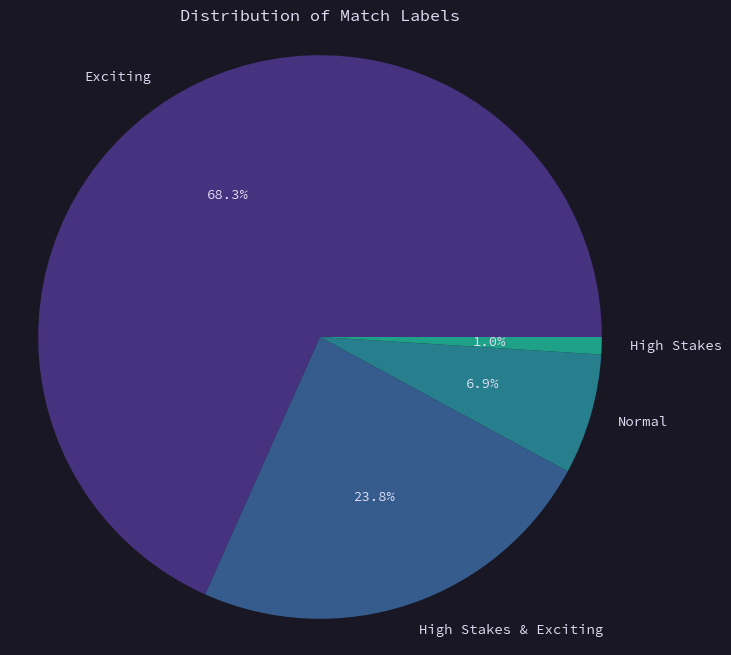


Processed data with masked text and summary saved to processed_data.tsv


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

# Load the data
df = pd.read_csv("23_24_match_details.csv", sep=",")

# Verify column names
print("Columns in the DataFrame:")
print(df.columns.tolist())

# Define comprehensive team name variations
team_variations = {
    "Team_1": ["Arsenal"],
    "Team_2": ["Aston Villa"],
    "Team_3": ["Bournemouth"],
    "Team_4": ["Brentford"],
    "Team_5": ["Brighton & Hove Albion", "Brighton"],
    "Team_6": ["Burnley"],
    "Team_7": ["Chelsea"],
    "Team_8": ["Crystal Palace"],
    "Team_9": ["Everton"],
    "Team_10": ["Fulham"],
    "Team_11": ["Liverpool"],
    "Team_12": ["Luton Town"],
    "Team_13": ["Manchester City", "Man City"],
    "Team_14": ["Manchester United"],
    "Team_15": ["Newcastle United", "Newcastle"],
    "Team_16": ["Nottingham Forest"],
    "Team_17": ["Sheffield United"],
    "Team_18": ["Tottenham Hotspur", "Tottenham"],
    "Team_19": ["West Ham United", "West Ham"],
    "Team_20": ["Wolves"],
}

# Create a reverse mapping dictionary with lowercase keys for case-insensitive matching
mask_mapping = {}
for team_label, variations in team_variations.items():
    for name in variations:
        mask_mapping[name.lower()] = team_label

print("\nMask Mapping Dictionary (Lowercased):")
print(mask_mapping)


# Function to replace team names in text with their masked counterparts
def mask_teams(text, mapping):
    if pd.isnull(text):
        return text
    # Sort team names by length in descending order to prevent partial matches
    sorted_teams = sorted(mapping.keys(), key=len, reverse=True)
    for team in sorted_teams:
        # Use word boundaries and case-insensitive matching
        # Also handle possessive forms (e.g., "Manchester City's")
        pattern = r"\b" + re.escape(team) + r"(?:'s)?\b"
        replacement = mapping[team]
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    return text


# Apply masking to 'Home' and 'Away' columns (convert to lowercase for mapping)
if "Home" in df.columns:
    df["Home_Masked"] = df["Home"].str.lower().map(mask_mapping)
else:
    print("\nColumn 'Home' not found in the dataset.")
    df["Home_Masked"] = np.nan

if "Away" in df.columns:
    df["Away_Masked"] = df["Away"].str.lower().map(mask_mapping)
else:
    print("\nColumn 'Away' not found in the dataset.")
    df["Away_Masked"] = np.nan

# Apply masking to 'events' and 'summary' columns
if "events" in df.columns:
    df["text_Masked"] = df["events"].apply(lambda x: mask_teams(x, mask_mapping))
else:
    print(
        "\nColumn 'events' not found in the dataset. Creating 'text_Masked' with NaN."
    )
    df["text_Masked"] = np.nan

if "summary" in df.columns:
    df["summary_Masked"] = df["summary"].apply(lambda x: mask_teams(x, mask_mapping))
else:
    print(
        "\nColumn 'summary' not found in the dataset. Creating 'summary_Masked' with NaN."
    )
    df["summary_Masked"] = np.nan

# Optional: Drop original 'Home' and 'Away' columns if no longer needed
# df = df.drop(['Home', 'Away'], axis=1)

# Display the masking results for verification
print("\nMasked Home and Away Teams:")
print(df[["Home", "Home_Masked", "Away", "Away_Masked"]].head())

# Display the original and masked text for the first row, if 'text_Masked' exists
if "text_Masked" in df.columns:
    print("\nOriginal and Masked Text for the First Row:")
    print(df[["events", "text_Masked"]].iloc[0])
else:
    print("\nColumn 'text_Masked' not found.")


# Function to check if any team names remain in the masked text
def check_unmasked(text, mapping):
    if pd.isnull(text):
        return False
    for team in mapping.keys():
        pattern = r"\b" + re.escape(team) + r"(?:'s)?\b"
        if re.search(pattern, text, flags=re.IGNORECASE):
            return True
    return False


# Apply the check to all masked texts and summaries
if "text_Masked" in df.columns:
    df["Unmasked_Teams_In_Text"] = df["text_Masked"].apply(
        lambda x: check_unmasked(x, mask_mapping)
    )
else:
    df["Unmasked_Teams_In_Text"] = False

if "summary_Masked" in df.columns:
    df["Unmasked_Teams_In_Summary"] = df["summary_Masked"].apply(
        lambda x: check_unmasked(x, mask_mapping)
    )
else:
    df["Unmasked_Teams_In_Summary"] = False

# Display rows where masking failed in 'text'
unmasked_texts = df[df["Unmasked_Teams_In_Text"]]
print("\nRows with Unmasked Team Names in 'text':")
if not unmasked_texts.empty:
    print(unmasked_texts[["id", "events", "text_Masked"]])
else:
    print("No unmasked team names found in 'text_Masked'.")

# Display rows where masking failed in 'summary'
unmasked_summaries = df[df["Unmasked_Teams_In_Summary"]]
print("\nRows with Unmasked Team Names in 'summary':")
if not unmasked_summaries.empty:
    print(unmasked_summaries[["id", "summary", "summary_Masked"]])
else:
    print("No unmasked team names found in 'summary_Masked'.")

# Enhanced keyword lists for labeling
high_stakes_keywords = [
    "title race",
    "relegation battle",
    "playoff",
    "derby",
    "rivalry",
    "crucial match",
    "promotion",
]
exciting_keywords = [
    "red card",
    "penalty",
    "hat-trick",
    "comeback",
    "late winner",
    "VAR review",
    "sent off",
    "suspension",
    "overtime",
    "intense",
]


def label_game_enhanced(text):
    if pd.isnull(text):
        return "Normal"
    text_lower = text.lower()
    high_stakes = any(keyword in text_lower for keyword in high_stakes_keywords)
    exciting = any(keyword in text_lower for keyword in exciting_keywords)

    if high_stakes and exciting:
        return "High Stakes & Exciting"
    elif high_stakes:
        return "High Stakes"
    elif exciting:
        return "Exciting"
    else:
        return "Normal"


# Apply the enhanced labeling function
if "text_Masked" in df.columns:
    df["Auto_Label"] = df["text_Masked"].apply(label_game_enhanced)
else:
    df["Auto_Label"] = "Normal"
    print("\nColumn 'text_Masked' not found. All matches labeled as 'Normal'.")

# Display the labeled data
print("\nLabeled Data:")
print(df[["id", "Home_Masked", "Away_Masked", "Auto_Label"]].head())

# Summary counts of labels
summary_counts = df["Auto_Label"].value_counts(dropna=True)
print("\nSummary Counts:")
print(summary_counts)

# Bar plot of label counts
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Auto_Label", palette="viridis")
plt.title("Count of Matches by Label")
plt.xlabel("Match Label")
plt.ylabel("Number of Matches")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pie chart of label distribution
plt.figure(figsize=(8, 8))
plt.pie(
    summary_counts,
    labels=summary_counts.index,
    autopct="%1.1f%%",
    colors=sns.color_palette("viridis"),
)
plt.title("Distribution of Match Labels")
plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Define the save path
save_path = "processed_data.tsv"

# Select relevant columns to save, including masked text and summary if available
columns_to_save = [
    "id",
    "Home_Masked",
    "Away_Masked",
    "Date",
    "Stadium",
    "Attendance",
    "Referee",
    "Auto_Label",
]

# Append "text_Masked" as "text" if available
if "text_Masked" in df.columns:
    df = df.rename(columns={"text_Masked": "text"})
    columns_to_save.append("text")

# Append "summary_Masked" as "summary" if available
if "summary_Masked" in df.columns:
    df = df.rename(columns={"summary_Masked": "summary"})
    columns_to_save.append("summary")

# Select only the columns to save and export to TSV
result_table = df[columns_to_save]
result_table.to_csv(save_path, sep="\t", index=False)

print(
    f"\nProcessed data with masked text{' and summary' if 'summary' in df.columns else ''} saved to {save_path}"
)

In [4]:
# Define paths for minimal examples
minimal_example_path = "lab7_minimal_example.tsv"
minimal_example_path2 = "lab7_minimal_example2.tsv"

# Ensure "text_Masked" is saved as "text" and "summary_Masked" as "summary"
if "text_Masked" in df.columns:
    df = df.rename(columns={"text_Masked": "text"})
if "summary_Masked" in df.columns:
    df = df.rename(columns={"summary_Masked": "summary"})

# Save one of each High Stakes & Exciting, High Stakes, Exciting, and Normal matches
minimal_example = df.groupby("Auto_Label").first().reset_index()
minimal_example = minimal_example[columns_to_save]

# Save the first minimal example
minimal_example.to_csv(minimal_example_path, sep="\t", index=False)

# Save another minimal example with different rows (last of each group)
minimal_example2 = df.groupby("Auto_Label").last().reset_index()
minimal_example2 = minimal_example2[columns_to_save]

# Save the second minimal example
minimal_example2.to_csv(minimal_example_path2, sep="\t", index=False)

print(f"Minimal examples saved as '{minimal_example_path}' and '{minimal_example_path2}'")

Minimal examples saved as 'lab7_minimal_example.tsv' and 'lab7_minimal_example2.tsv'
